# Sampling
Sampling the loss manifold using GLA 2nd


In [1]:
import sys
sys.path.append('/Users/zofia/packages/DataDrivenSampler-0.3/lib/python3.6/site-packages')

In [2]:
from DataDrivenSampler.models.model import model
import numpy as np
FLAGS = model.setup_parameters(
    batch_data_files=["dataset-twoclusters.csv"],
    batch_size=500,
    max_steps=1000,
    output_activation="linear",
    sampler="GeometricLangevinAlgorithm_2ndOrder",
    seed=426,
    step_width=1e-2
)
nn = model(FLAGS)
nn.init_network(None, setup="sample")
run_info, trajectory = nn.sample(return_run_info=True, \
  return_trajectories=True)
nn.finish()
print("Sample results")
print(np.asarray(run_info[0:10]))
print(np.asarray(trajectory[0:10]))

/Users/zofia/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Parsing ['dataset-twoclusters.csv']
(TensorShape([Dimension(None), Dimension(2)]), TensorShape([Dimension(None), Dimension(1)]))
(tf.float32, tf.int32)
Picking as input columns: ['x1', 'x2']
x is (?, 2)
Creating nn layer output with 2, 1
Setting up output files for sample
Weight: <tf.Variable 'output/weights/Variable:0' shape=(2, 1) dtype=float64_ref>
Placeholder: Tensor("Placeholder:0", shape=(2, 1), dtype=float64)
Weight: <tf.Variable 'output/biases/Variable:0' shape=(1,) dtype=float64_ref>
Placeholder: Tensor("Placeholder_1:0", shape=(1,), dtype=float64)
Starting to sample
SAMPLED.
Sample results
[[1.0 0.0 '0.000' '4.16186523e+00' '5.28120000e-02' '4.16362175e+00'
  '1.75651877e-03' '1.18541766e-01' '1.18541766e-01' '2.12819406e+00'
  '0.00000000e+00' '1.75651877e-03' '2.12819406e+00']
 [2.0 1.0 '0.000' '4.14782476e+00' '9.46000000e-03' '4.16361549e+00'
  '1.57907237e-02' '2.36881630e-01' '1.18339864e-01' '2.11757114e+00'
  '0.00000000e+00' '8.77362125e-03' '2.12288260e+00']
 [3.0 2

In [3]:
import pandas as pd 
df = pd.DataFrame(trajectory)
df.to_csv("run_gla2.csv")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_run = pd.read_csv("run_gla2.csv", sep=',', header=0)

loss=np.squeeze(np.asarray(df_run.loc[:,['loss']]))
step=np.squeeze(np.asarray(df_run.loc[:,['step']]))
weights=np.asarray(df_run.loc[:,['weight0', 'weight1', 'bias0']])
run=np.asarray(df_run.loc[:,['step','loss','kinetic_energy', 'total_energy']])


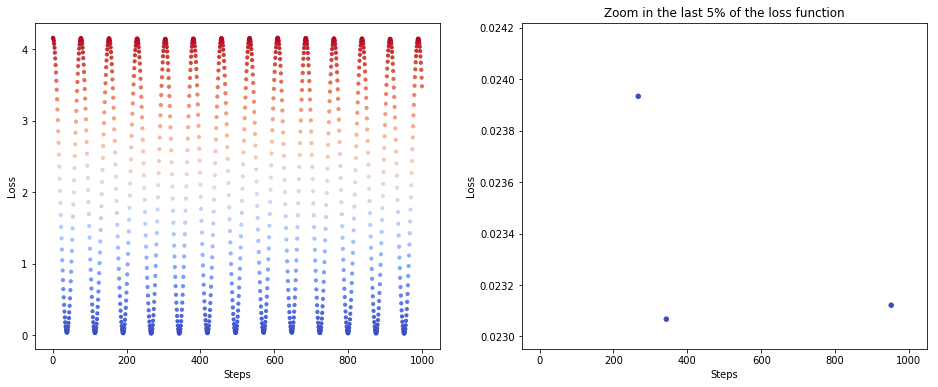

In [5]:
from matplotlib import cm

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)
ax.scatter(step, loss, c = loss, s=10,  cmap=cm.coolwarm)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')


ax = fig.add_subplot(122)
ax.scatter(step, loss, c = loss, s=20,  cmap=cm.coolwarm)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_ylim([0.995*np.min(loss),1.05*np.min(loss)])
ax.set_title('Zoom in the last 5% of the loss function')

plt.show()

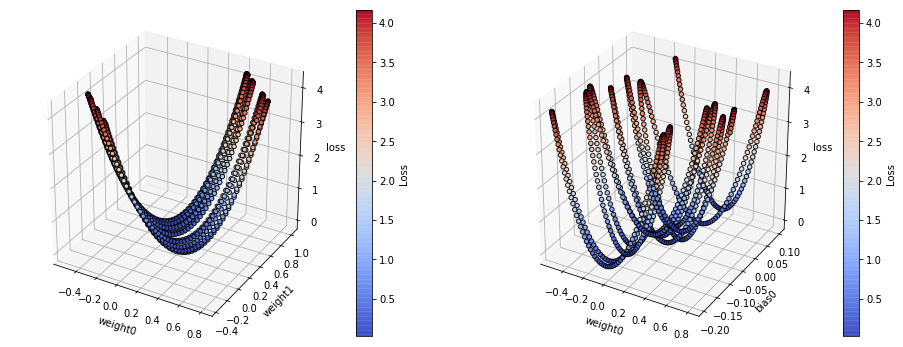

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121, projection='3d')
axf = ax.scatter(weights[:,0], weights[:,1], loss, c=loss, alpha=0.90, edgecolors='none', depthshade=True,  cmap=cm.coolwarm)
cbar = fig.colorbar(axf)
cbar.set_label('Loss')
ax.set_xlabel(df_run.axes[1][-3])
ax.set_ylabel(df_run.axes[1][-2])
ax.set_zlabel(df_run.axes[1][2])

ax = fig.add_subplot(122, projection='3d')
axf = ax.scatter(weights[:,0], weights[:,2], loss, c=loss, alpha=0.90, edgecolors='none', depthshade=True,  cmap=cm.coolwarm)
cbar = fig.colorbar(axf)
cbar.set_label('Loss')
ax.set_xlabel(df_run.axes[1][-3])
ax.set_ylabel(df_run.axes[1][-1])
ax.set_zlabel(df_run.axes[1][2])

plt.show()

# Averages

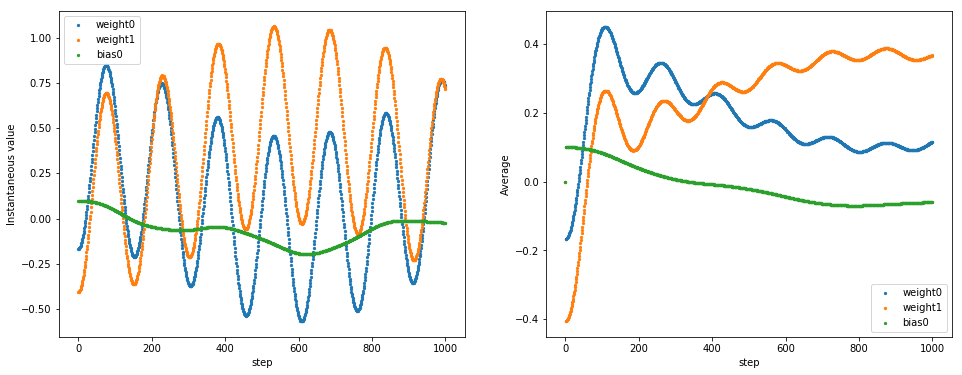

In [18]:
averages = np.zeros(weights.shape)

for i in range(1,weights.shape[0]):
    for d in range(weights.shape[1]):
        averages[i,d]=np.mean(weights[:i,d])

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)

[ax.scatter(range(len(weights)), weights[:,i], s=5) for i in range(weights.shape[1])]
ax.set_xlabel('step')
ax.set_ylabel('Instantaneous value')
ax.legend(df_run.axes[1][-3:])

ax = fig.add_subplot(122)
[ax.scatter(range(len(weights)), averages[:,i], s=5) for i in range(weights.shape[1])]
ax.set_xlabel('step')
ax.set_ylabel('Average')
ax.legend(df_run.axes[1][-3:])

plt.show()


# Optimizing first and subsequent sampling
This is actually the recommended way of doing sampling: First make sure that the parameters start in a local minima and from there we explore the surrounding manifold.

In [8]:
from DataDrivenSampler.models.model import model
import numpy as np
FLAGS = model.setup_parameters(
batch_data_files=["dataset-twoclusters.csv"],
            batch_size=500,
            max_steps=100,
            optimizer="GradientDescent",
            output_activation="linear",
            seed=426,
            step_width=1e-2
        )
nn = model(FLAGS)
nn.init_network(None, setup="train")
opt_run_info, opt_trajectory = nn.train( return_run_info=True, return_trajectories=True)
FLAGS.max_steps = 1000
FLAGS.sampler = "GeometricLangevinAlgorithm_2ndOrder"
nn.reset_parameters(FLAGS)
nn.init_network(None, setup="sample")
# reset the dataset to make it start at the beginning again
# otherwise you get error: epoch ended to early!
nn.reset_dataset()

sample_run_info, sample_trajectory = nn.sample( return_run_info=True, return_trajectories=True)
nn.finish()
print("Sample results")
print(np.asarray(sample_run_info[0:10]))
print(np.asarray(sample_trajectory[0:10]))


Parsing ['dataset-twoclusters.csv']
(TensorShape([Dimension(None), Dimension(2)]), TensorShape([Dimension(None), Dimension(1)]))
(tf.float32, tf.int32)
Picking as input columns: ['x1', 'x2']
x is (?, 2)
Creating nn layer output with 2, 1
Setting up output files for train
Weight: <tf.Variable 'output/weights/Variable:0' shape=(2, 1) dtype=float64_ref>
Placeholder: Tensor("Placeholder:0", shape=(2, 1), dtype=float64)
Weight: <tf.Variable 'output/biases/Variable:0' shape=(1,) dtype=float64_ref>
Placeholder: Tensor("Placeholder_1:0", shape=(1,), dtype=float64)
Starting to train
TRAINED down to loss 0.0293163 and accuracy 1.0.
Setting up output files for sample
Weight: <tf.Variable 'output/weights/Variable:0' shape=(2, 1) dtype=float64_ref>
Placeholder: Tensor("Placeholder_2:0", shape=(2, 1), dtype=float64)
Weight: <tf.Variable 'output/biases/Variable:0' shape=(1,) dtype=float64_ref>
Placeholder: Tensor("Placeholder_3:0", shape=(1,), dtype=float64)
Starting to sample
SAMPLED.
Sample results

In [9]:
import pandas as pd 
df = pd.DataFrame(sample_trajectory)
df.to_csv("run_gla2_optimizeFirst.csv")

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_run = pd.read_csv("run_gla2_optimizeFirst.csv", sep=',', header=0)
run=np.asarray(df_run.loc[:,['step','loss','kinetic_energy', 'total_energy']])

loss=np.squeeze(np.asarray(df_run.loc[:,['loss']]))
step=np.squeeze(np.asarray(df_run.loc[:,['step']]))
weights=np.asarray(df_run.loc[:,['weight0', 'weight1', 'bias0']])
run=np.asarray(df_run.loc[:,['step','loss','kinetic_energy', 'total_energy']])


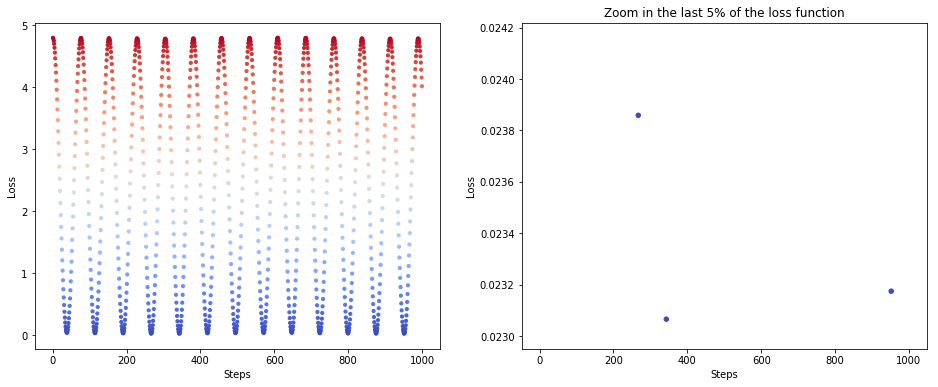

In [11]:
from matplotlib import cm

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)
ax.scatter(step, loss, c = loss, s=10,  cmap=cm.coolwarm)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')


ax = fig.add_subplot(122)
ax.scatter(step, loss, c = loss, s=20,  cmap=cm.coolwarm)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_ylim([0.995*np.min(loss),1.05*np.min(loss)])
ax.set_title('Zoom in the last 5% of the loss function')

plt.show()

# Averages

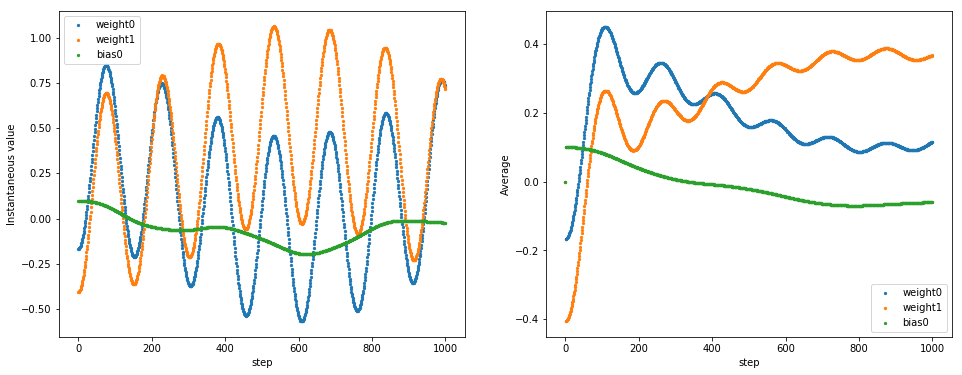

In [12]:
averages = np.zeros(weights.shape)

for i in range(1,weights.shape[0]):
    for d in range(weights.shape[1]):
        averages[i,d]=np.mean(weights[:i,d])

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)

[ax.scatter(range(len(weights)), weights[:,i], s=5) for i in range(weights.shape[1])]
ax.set_xlabel('step')
ax.set_ylabel('Instantaneous value')
ax.legend(df_run.axes[1][-3:])

ax = fig.add_subplot(122)
[ax.scatter(range(len(weights)), averages[:,i], s=5) for i in range(weights.shape[1])]
ax.set_xlabel('step')
ax.set_ylabel('Average')
ax.legend(df_run.axes[1][-3:])

plt.show()

